In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import SplineTransformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge

In [3]:
def generate_data(n=1000):
    x = np.random.uniform(0, 4, n)
    y = 4.26 * (
        np.exp(-x) - 4 * np.exp(-2 * x) + 3 * np.exp(-3 * x)
    ) + np.random.normal(0, 0.1, n)
    return x, y

In [45]:
def plot_data(x, y, x_sorted, title="How generated data looks like"):
    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, s=15, alpha=0.6, label="Generated data", c="darkslategrey")
    plt.plot(
        np.linspace(0, 4, 1000),
        4.26
        * (
            np.exp(-np.linspace(0, 4, 1000))
            - 4 * np.exp(-2 * np.linspace(0, 4, 1000))
            + 3 * np.exp(-3 * np.linspace(0, 4, 1000))
        ),
        c="orangered",
        label="True function",
        linewidth=4,
        linestyle="dashed",
    )
    plt.xlabel("x", fontsize=12)
    plt.ylabel("y", rotation=0, labelpad=15, fontsize=12)
    plt.grid(True)
    plt.gca().yaxis.grid(color="gray", alpha=0.2)
    plt.gca().xaxis.grid(color="gray", alpha=0.2)
    plt.title(title, fontsize=15)

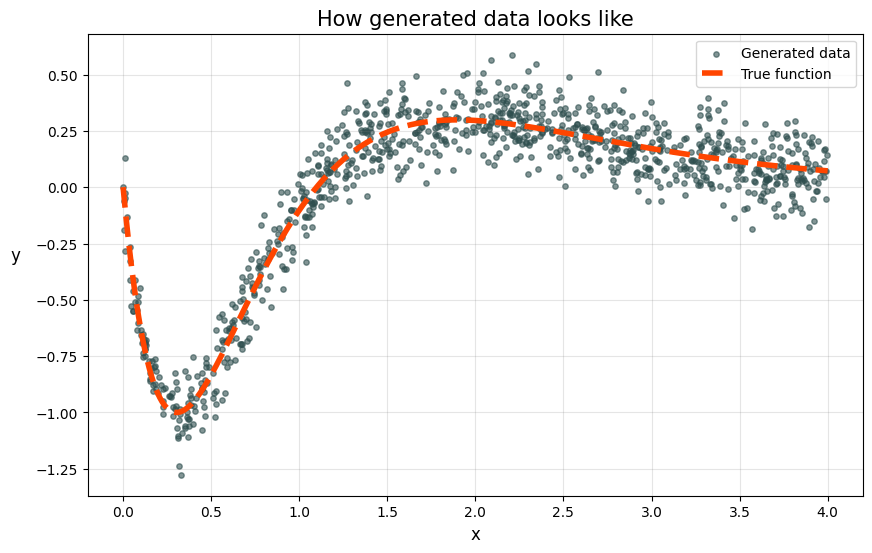

In [46]:
x, y = generate_data()
x_sorted = np.sort(x)
plot_data(x, y, x_sorted)
plt.legend(fontsize=10)

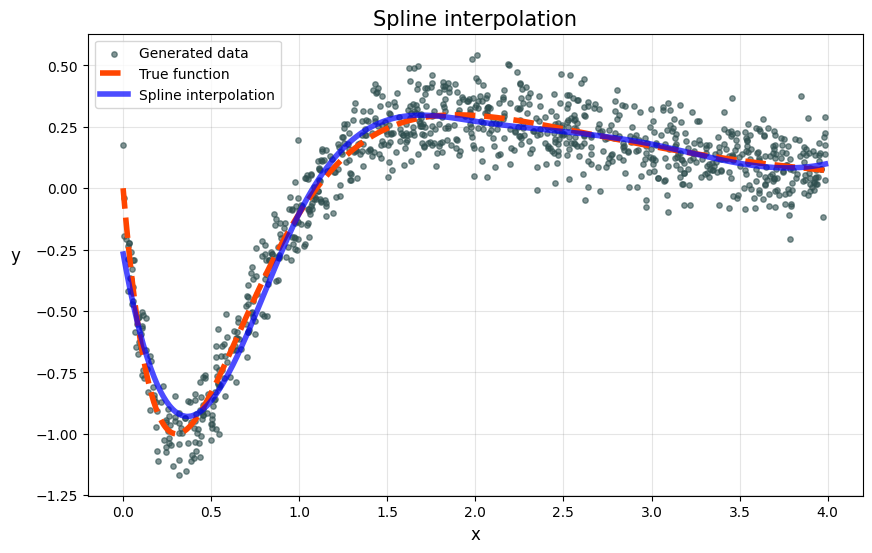

In [51]:
# Generate data
x, y = generate_data(n=1000)
x_sorted = np.sort(x)

# Spline interpolation
spliner = SplineTransformer()
model = make_pipeline(spliner, Ridge(alpha=1e-10))
model.fit(x[:, np.newaxis], y)
spline_predictions = model.predict(x_sorted[:, np.newaxis])

# Plot
plot_data(x, y, x_sorted, title="Spline interpolation")
plt.plot(
    x_sorted,
    spline_predictions,
    c="blue",
    label="Spline interpolation",
    linewidth=4,
    alpha=0.7,
)
plt.legend(fontsize=10)